# 스쿼트 파운데이션 모델 벤치마크 노트북

이 노트북은 라벨링된 스쿼트 데이터셋으로 CNN, CNN-GRU, ViT 기반 모델을 학습·평가해 성능을 비교하기 위한 베이스라인 워크플로를 제공합니다. 아래 순서를 따라가면서 데이터를 불러오고, 증강을 적용하고, 각 모델을 학습/검증/테스트할 수 있습니다.

## 1. 환경 설정 및 공통 유틸리티

In [1]:
import sys
import json
import importlib
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8')

# 프로젝트 소스 경로 자동 탐색
NOTEBOOK_DIR = Path.cwd().resolve()
CANDIDATES = [
    NOTEBOOK_DIR,
    NOTEBOOK_DIR.parent,
    NOTEBOOK_DIR.parent.parent,
]
PROJECT_ROOT = None
for candidate in CANDIDATES:
    if (candidate / 'src').is_dir():
        PROJECT_ROOT = candidate
        break

if PROJECT_ROOT is None:
    raise RuntimeError('프로젝트 루트를 찾을 수 없습니다. 리포지토리 루트에서 노트북을 실행해 주세요.')

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.augmentations import (
    add_gaussian_noise,
    compose_transforms,
    random_time_shift,
    random_time_stretch,
    random_time_warp,
    random_scaling,
)
import src.data_loading as data_loading
importlib.reload(data_loading)
from src.data_loading import (
    DatasetLayout,
    SquatClass,
    SQUAT_CLASS_GUIDE,
    SquatWindowDataset,
    iter_class_counts,
    make_dataloader,
    train_val_test_split,
)
from src.models import TemporalCNNGRU

torch.manual_seed(41)
np.random.seed(41)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


/Users/Jae/Projects/squat_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

## 2. 데이터셋 구성 및 탐색

In [2]:
# 데이터와 결과 저장 경로 설정
DATA_ROOT = (PROJECT_ROOT / "data").resolve()
RESULTS_DIR = (PROJECT_ROOT / "results" / "foundation_models").resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

layout = DatasetLayout(DATA_ROOT)
layout

DatasetLayout(root=PosixPath('/Users/Jae/Projects/squat_project/data'))

In [3]:
# 증강 파이프라인 정의 및 원본 데이터 로드
TARGET_LENGTH = 512

train_transforms = compose_transforms(
    [
        random_time_shift(max_shift=5),
        random_scaling(0.9, 1.1),
        random_time_stretch(0.85, 1.2),
        random_time_warp(0.15),
        add_gaussian_noise(0.01),
    ]
)

raw_dataset = SquatWindowDataset(
    layout.manually_labeled,
    transforms=None,
    drop_columns=('timestamp',),
    target_length=TARGET_LENGTH,
)
len(raw_dataset)


400

In [4]:
# 클래스별 샘플 분포 및 길이 확인
counts = list(iter_class_counts(raw_dataset))
lengths = {raw_dataset[idx][0].shape[1] for idx in range(len(raw_dataset))}
print(f"고유 윈도우 길이: {sorted(lengths)}")
pd.DataFrame([(cls.name, count) for cls, count in counts], columns=['class', 'count'])


고유 윈도우 길이: [512]


,class,count
0,CORRECT,80
1,KNEE_VALGUS,80
2,BUTT_WINK,80
3,EXCESSIVE_LEAN,80
4,PARTIAL_SQUAT,80


In [5]:
# 학습/검증/테스트 분할 및 데이터로더 생성
train_subset, val_subset, test_subset = train_val_test_split(raw_dataset, ratios=(0.7, 0.15, 0.15), seed=41)

class AugmentedSubset(Dataset):
    def __init__(self, subset: Subset, transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None) -> None:
        self.subset = subset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.subset)

    def __getitem__(self, index: int):
        window, label = self.subset[index]
        if self.transform is not None:
            window = self.transform(window)
        return window, label

train_dataset = AugmentedSubset(train_subset, transform=train_transforms)
val_dataset = AugmentedSubset(val_subset)
test_dataset = AugmentedSubset(test_subset)

train_loader = make_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = make_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = make_dataloader(test_dataset, batch_size=64, shuffle=False)

next(iter(train_loader))[0].shape


torch.Size([64, 23, 512])

## 3. 공통 학습 루틴 정의

In [6]:
@dataclass
class TrainingConfig:
    epochs: int = 30
    learning_rate: float = 3e-4
    weight_decay: float = 1e-3
    grad_clip: float = 5.0


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    config: "TrainingConfig",
) -> float:
    model.train()
    total_loss, total_samples = 0.0, 0

    for batch, targets in tqdm(loader, desc="train", leave=False):
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        logits = model(batch)
        loss = criterion(logits, targets)
        loss.backward()
        if config.grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        optimizer.step()

        total_loss += loss.item() * batch.size(0)
        total_samples += batch.size(0)

    return total_loss / max(total_samples, 1)


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> Dict[str, float]:
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for batch, targets in tqdm(loader, desc="eval", leave=False):
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)
        logits = model(batch)
        loss = criterion(logits, targets)

        total_loss += loss.item() * batch.size(0)
        total_correct += (logits.argmax(dim=1) == targets).sum().item()
        total_samples += batch.size(0)

    return {
        "loss": total_loss / max(total_samples, 1),
        "accuracy": total_correct / max(total_samples, 1),
    }


def fit(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: "TrainingConfig",
) -> Tuple[nn.Module, Dict[str, List[float]]]:
    model = model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    best_score = 0.0
    best_state = None

    for epoch in range(1, config.epochs + 1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, config)
        metrics = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(metrics["loss"])
        history["val_acc"].append(metrics["accuracy"])

        if metrics["accuracy"] > best_score:
            best_score = metrics["accuracy"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={metrics['loss']:.4f} | val_acc={metrics['accuracy']:.3%}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


config = TrainingConfig(epochs=30, learning_rate=3e-4, weight_decay=1e-3, grad_clip=5.0)
config


TrainingConfig(epochs=30, learning_rate=0.0003, weight_decay=0.001, grad_clip=5.0)

## 4. 모델 정의

기본 CNN, CNN-GRU(TemporalCNNGRU), IMU 전용 ViT를 설정합니다.

In [7]:
class CNNBaseline(nn.Module):
    """간단한 1D CNN 분류기."""

    def __init__(self, in_channels: int, num_classes: int) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ViTSensor(nn.Module):
    """간단한 시계열 Vision Transformer."""

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        seq_len: int,
        patch_size: int = 16,
        dim: int = 128,
        depth: int = 4,
        heads: int = 4,
        mlp_ratio: float = 2.0,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()
        assert seq_len % patch_size == 0, "Sequence length must be divisible by patch size."
        self.patch_size = patch_size
        self.num_patches = seq_len // patch_size
        self.patch_dim = in_channels * patch_size

        self.to_patch_embedding = nn.Sequential(
            nn.Unfold(kernel_size=(1, patch_size), stride=(1, patch_size)),
        )
        self.linear_proj = nn.Linear(self.patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=int(dim * mlp_ratio),
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, t = x.shape
        x = x.unsqueeze(2)  # (b, c, 1, t)
        patches = self.to_patch_embedding(x)  # (b, c * patch_size, num_patches)
        patches = patches.transpose(1, 2)  # (b, num_patches, patch_dim)
        tokens = self.linear_proj(patches)

        cls_tokens = self.cls_token.repeat(b, 1, 1)
        tokens = torch.cat([cls_tokens, tokens], dim=1)
        tokens = tokens + self.pos_embedding[:, : tokens.size(1), :]

        encoded = self.transformer(tokens)
        return self.mlp_head(encoded[:, 0])

class CNNLSTM(nn.Module):
    """CNN feature extractor followed by an LSTM head."""

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        conv_channels: int = 64,
        hidden_size: int = 128,
        num_layers: int = 1,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, conv_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv_channels, conv_channels, kernel_size=5, padding=2),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_size * 2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.encoder(x)
        sequence = features.transpose(1, 2)
        output, _ = self.lstm(sequence)
        pooled = output.mean(dim=1)
        return self.head(pooled)


## 5. 학습 및 검증

모델별로 학습을 수행하고, 검증 성능을 비교합니다.

In [8]:
def infer_input_shape(loader: DataLoader) -> Tuple[int, int]:
    sample, _ = next(iter(loader))
    return sample.size(1), sample.size(2)


in_channels, seq_len = infer_input_shape(train_loader)
num_classes = 5

model_factories: Dict[str, Callable[[], nn.Module]] = {
    "CNNBaseline": lambda: CNNBaseline(in_channels, num_classes),
    "CNNLSTM": lambda: CNNLSTM(in_channels, num_classes),
    "TemporalCNNGRU": lambda: TemporalCNNGRU(in_channels=in_channels, num_classes=num_classes),
    "ViTSensor": lambda: ViTSensor(in_channels=in_channels, num_classes=num_classes, seq_len=seq_len, patch_size=16),
}

histories: Dict[str, Dict[str, List[float]]] = {}
val_metrics: Dict[str, Dict[str, float]] = {}
trained_models: Dict[str, nn.Module] = {}

for name, factory in model_factories.items():
    print(f"\n=== Training: {name} ===")
    model = factory()
    model, history = fit(model, train_loader, val_loader, config)
    metrics = evaluate(model, val_loader, nn.CrossEntropyLoss())

    histories[name] = history
    val_metrics[name] = metrics
    trained_models[name] = model

pd.DataFrame(val_metrics).T


=== Training: CNNBaseline ===


Epoch 001 | train_loss=1.5168 | val_loss=1.8517 | val_acc=31.667%


Epoch 002 | train_loss=1.4025 | val_loss=1.5991 | val_acc=38.333%


Epoch 003 | train_loss=1.3423 | val_loss=1.4154 | val_acc=45.000%


Epoch 004 | train_loss=1.3105 | val_loss=1.2880 | val_acc=46.667%


Epoch 005 | train_loss=1.2900 | val_loss=1.2178 | val_acc=60.000%


Epoch 006 | train_loss=1.2643 | val_loss=1.1773 | val_acc=60.000%


Epoch 007 | train_loss=1.2635 | val_loss=1.1533 | val_acc=51.667%


Epoch 008 | train_loss=1.2197 | val_loss=1.1445 | val_acc=48.333%


Epoch 009 | train_loss=1.1935 | val_loss=1.1294 | val_acc=43.333%


Epoch 010 | train_loss=1.1967 | val_loss=1.1304 | val_acc=43.333%


Epoch 011 | train_loss=1.1608 | val_loss=1.1445 | val_acc=45.000%


Epoch 012 | train_loss=1.1636 | val_loss=1.1680 | val_acc=45.000%


Epoch 013 | train_loss=1.1587 | val_loss=1.1561 | val_acc=45.000%


Epoch 014 | train_loss=1.1337 | val_loss=1.1307 | val_acc=46.667%


Epoch 015 | train_loss=1.1396 | val_loss=1.1726 | val_acc=46.667%


Epoch 016 | train_loss=1.1510 | val_loss=1.1809 | val_acc=41.667%


Epoch 017 | train_loss=1.1055 | val_loss=1.1002 | val_acc=46.667%


Epoch 018 | train_loss=1.1040 | val_loss=1.0506 | val_acc=50.000%


Epoch 019 | train_loss=1.0995 | val_loss=1.0960 | val_acc=46.667%


Epoch 020 | train_loss=1.0805 | val_loss=1.0967 | val_acc=46.667%


Epoch 021 | train_loss=1.1232 | val_loss=1.0373 | val_acc=50.000%


Epoch 022 | train_loss=1.0891 | val_loss=1.0617 | val_acc=50.000%


Epoch 023 | train_loss=1.0775 | val_loss=1.0346 | val_acc=50.000%


Epoch 024 | train_loss=1.0509 | val_loss=1.0068 | val_acc=50.000%


Epoch 025 | train_loss=1.1125 | val_loss=1.0220 | val_acc=50.000%


Epoch 026 | train_loss=1.0571 | val_loss=1.0230 | val_acc=51.667%


Epoch 027 | train_loss=1.0164 | val_loss=1.0368 | val_acc=50.000%


Epoch 028 | train_loss=1.0787 | val_loss=1.0083 | val_acc=50.000%


Epoch 029 | train_loss=1.0987 | val_loss=1.0005 | val_acc=53.333%


Epoch 030 | train_loss=1.0559 | val_loss=1.0714 | val_acc=51.667%



=== Training: CNNLSTM ===


Epoch 001 | train_loss=1.4896 | val_loss=1.6853 | val_acc=31.667%


Epoch 002 | train_loss=1.2587 | val_loss=1.5728 | val_acc=35.000%


Epoch 003 | train_loss=1.2289 | val_loss=1.2614 | val_acc=46.667%


Epoch 004 | train_loss=1.1416 | val_loss=1.1125 | val_acc=58.333%


Epoch 005 | train_loss=1.1208 | val_loss=1.0716 | val_acc=55.000%


Epoch 006 | train_loss=1.0865 | val_loss=1.0504 | val_acc=53.333%


Epoch 007 | train_loss=1.0757 | val_loss=1.0451 | val_acc=48.333%


Epoch 008 | train_loss=1.0831 | val_loss=1.0468 | val_acc=46.667%


Epoch 009 | train_loss=1.0725 | val_loss=1.0436 | val_acc=50.000%


Epoch 010 | train_loss=1.0080 | val_loss=1.0752 | val_acc=50.000%


Epoch 011 | train_loss=1.0384 | val_loss=1.0297 | val_acc=55.000%


Epoch 012 | train_loss=0.9961 | val_loss=1.0026 | val_acc=56.667%


Epoch 013 | train_loss=1.0509 | val_loss=0.9952 | val_acc=55.000%


Epoch 014 | train_loss=0.9708 | val_loss=0.9924 | val_acc=50.000%


Epoch 015 | train_loss=1.0101 | val_loss=0.9930 | val_acc=51.667%


Epoch 016 | train_loss=1.0596 | val_loss=1.1279 | val_acc=40.000%


Epoch 017 | train_loss=1.0752 | val_loss=1.0677 | val_acc=46.667%


Epoch 018 | train_loss=1.0474 | val_loss=0.9506 | val_acc=55.000%


Epoch 019 | train_loss=1.0246 | val_loss=0.9738 | val_acc=58.333%


Epoch 020 | train_loss=1.0070 | val_loss=0.9978 | val_acc=55.000%


Epoch 021 | train_loss=1.0459 | val_loss=1.0836 | val_acc=41.667%


Epoch 022 | train_loss=0.9859 | val_loss=0.9966 | val_acc=48.333%


Epoch 023 | train_loss=1.0403 | val_loss=1.0532 | val_acc=50.000%


Epoch 024 | train_loss=1.0713 | val_loss=1.1902 | val_acc=41.667%


Epoch 025 | train_loss=0.9972 | val_loss=0.9484 | val_acc=53.333%


Epoch 026 | train_loss=1.0105 | val_loss=0.9515 | val_acc=58.333%


Epoch 027 | train_loss=0.9574 | val_loss=0.9290 | val_acc=56.667%


Epoch 028 | train_loss=1.0682 | val_loss=0.9475 | val_acc=56.667%


Epoch 029 | train_loss=1.0116 | val_loss=0.9488 | val_acc=50.000%


Epoch 030 | train_loss=0.9899 | val_loss=1.0837 | val_acc=36.667%



=== Training: TemporalCNNGRU ===


Epoch 001 | train_loss=1.5295 | val_loss=1.6144 | val_acc=31.667%


Epoch 002 | train_loss=1.3030 | val_loss=1.4791 | val_acc=40.000%


Epoch 003 | train_loss=1.2082 | val_loss=1.2490 | val_acc=51.667%


Epoch 004 | train_loss=1.1342 | val_loss=1.0983 | val_acc=61.667%


Epoch 005 | train_loss=1.1260 | val_loss=1.0337 | val_acc=63.333%


Epoch 006 | train_loss=1.1174 | val_loss=1.0280 | val_acc=61.667%


Epoch 007 | train_loss=1.0684 | val_loss=1.0707 | val_acc=55.000%


Epoch 008 | train_loss=1.0703 | val_loss=1.1374 | val_acc=48.333%


Epoch 009 | train_loss=1.1004 | val_loss=1.1115 | val_acc=46.667%


Epoch 010 | train_loss=1.0174 | val_loss=1.1004 | val_acc=50.000%


Epoch 011 | train_loss=1.0094 | val_loss=1.1359 | val_acc=53.333%


Epoch 012 | train_loss=1.0226 | val_loss=1.0900 | val_acc=51.667%


Epoch 013 | train_loss=1.0118 | val_loss=1.0624 | val_acc=50.000%


Epoch 014 | train_loss=1.0373 | val_loss=1.0437 | val_acc=55.000%


Epoch 015 | train_loss=1.0314 | val_loss=1.1326 | val_acc=43.333%


Epoch 016 | train_loss=1.0090 | val_loss=0.9819 | val_acc=53.333%


Epoch 017 | train_loss=1.0161 | val_loss=0.9660 | val_acc=51.667%


Epoch 018 | train_loss=1.0266 | val_loss=0.9406 | val_acc=55.000%


Epoch 019 | train_loss=0.9667 | val_loss=0.9216 | val_acc=56.667%


Epoch 020 | train_loss=0.9732 | val_loss=0.9706 | val_acc=55.000%


Epoch 021 | train_loss=0.9464 | val_loss=0.9844 | val_acc=53.333%


Epoch 022 | train_loss=0.9858 | val_loss=1.0015 | val_acc=53.333%


Epoch 023 | train_loss=1.0525 | val_loss=0.9671 | val_acc=55.000%


Epoch 024 | train_loss=0.9810 | val_loss=1.1654 | val_acc=40.000%


Epoch 025 | train_loss=1.0118 | val_loss=1.0947 | val_acc=40.000%


Epoch 026 | train_loss=1.0352 | val_loss=1.0220 | val_acc=60.000%


Epoch 027 | train_loss=1.0477 | val_loss=0.9886 | val_acc=55.000%


Epoch 028 | train_loss=0.9895 | val_loss=0.9803 | val_acc=50.000%


Epoch 029 | train_loss=1.0307 | val_loss=1.0501 | val_acc=41.667%


Epoch 030 | train_loss=0.9800 | val_loss=1.0009 | val_acc=51.667%



=== Training: ViTSensor ===


Epoch 001 | train_loss=1.6329 | val_loss=1.6208 | val_acc=16.667%


Epoch 002 | train_loss=1.6243 | val_loss=1.6814 | val_acc=16.667%


Epoch 003 | train_loss=1.6162 | val_loss=1.6566 | val_acc=18.333%


Epoch 004 | train_loss=1.6115 | val_loss=1.6359 | val_acc=18.333%


Epoch 005 | train_loss=1.6167 | val_loss=1.6328 | val_acc=18.333%


Epoch 006 | train_loss=1.6137 | val_loss=1.6445 | val_acc=10.000%


Epoch 007 | train_loss=1.6137 | val_loss=1.6417 | val_acc=16.667%


Epoch 008 | train_loss=1.5994 | val_loss=1.6382 | val_acc=16.667%


Epoch 009 | train_loss=1.6147 | val_loss=1.6231 | val_acc=16.667%


Epoch 010 | train_loss=1.6070 | val_loss=1.6277 | val_acc=16.667%


Epoch 011 | train_loss=1.6084 | val_loss=1.6282 | val_acc=16.667%


Epoch 012 | train_loss=1.6077 | val_loss=1.6287 | val_acc=16.667%


Epoch 013 | train_loss=1.6094 | val_loss=1.6401 | val_acc=16.667%


Epoch 014 | train_loss=1.6115 | val_loss=1.6287 | val_acc=10.000%


Epoch 015 | train_loss=1.6121 | val_loss=1.6357 | val_acc=16.667%


Epoch 016 | train_loss=1.6071 | val_loss=1.6406 | val_acc=16.667%


Epoch 017 | train_loss=1.6088 | val_loss=1.6399 | val_acc=16.667%


Epoch 018 | train_loss=1.6066 | val_loss=1.6273 | val_acc=16.667%


Epoch 019 | train_loss=1.6060 | val_loss=1.6236 | val_acc=16.667%


Epoch 020 | train_loss=1.6056 | val_loss=1.6236 | val_acc=16.667%


Epoch 021 | train_loss=1.6071 | val_loss=1.6242 | val_acc=16.667%


Epoch 022 | train_loss=1.6099 | val_loss=1.6309 | val_acc=16.667%


Epoch 023 | train_loss=1.6139 | val_loss=1.6391 | val_acc=16.667%


Epoch 024 | train_loss=1.6159 | val_loss=1.6391 | val_acc=18.333%


Epoch 025 | train_loss=1.6089 | val_loss=1.6277 | val_acc=16.667%


Epoch 026 | train_loss=1.6084 | val_loss=1.6230 | val_acc=16.667%


Epoch 027 | train_loss=1.6109 | val_loss=1.6171 | val_acc=16.667%


Epoch 028 | train_loss=1.6112 | val_loss=1.6099 | val_acc=16.667%


Epoch 029 | train_loss=1.6129 | val_loss=1.6168 | val_acc=16.667%


Epoch 030 | train_loss=1.6106 | val_loss=1.6317 | val_acc=16.667%


,loss,accuracy
CNNBaseline,1.217762,0.600000
CNNLSTM,1.112496,0.583333
TemporalCNNGRU,1.033735,0.633333
ViTSensor,1.656578,0.183333


## 6. 테스트 세트 평가

In [9]:
test_results = {}
criterion = nn.CrossEntropyLoss()

for name, model in trained_models.items():
    metrics = evaluate(model, test_loader, criterion)
    test_results[name] = metrics
    print(f"{name} | test_loss={metrics['loss']:.4f} | test_acc={metrics['accuracy']:.3%}")

test_df = pd.DataFrame(test_results).T
test_df

CNNBaseline | test_loss=1.3545 | test_acc=50.000%


CNNLSTM | test_loss=1.2302 | test_acc=43.333%


TemporalCNNGRU | test_loss=1.1028 | test_acc=60.000%


ViTSensor | test_loss=1.6233 | test_acc=20.000%


,loss,accuracy
CNNBaseline,1.354535,0.500000
CNNLSTM,1.230200,0.433333
TemporalCNNGRU,1.102813,0.600000
ViTSensor,1.623329,0.200000


## 8. 학습 곡선과 성능 시각화
훈련 기록을 시각화해 모델별 수렴 패턴과 최종 성능을 비교합니다.


/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/1953493935.py:30: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/1953493935.py:30: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) Arial.
  plt.tight_layout()
/Users/Jae/Projects/squat_project/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Jae/Projects/squat_project/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


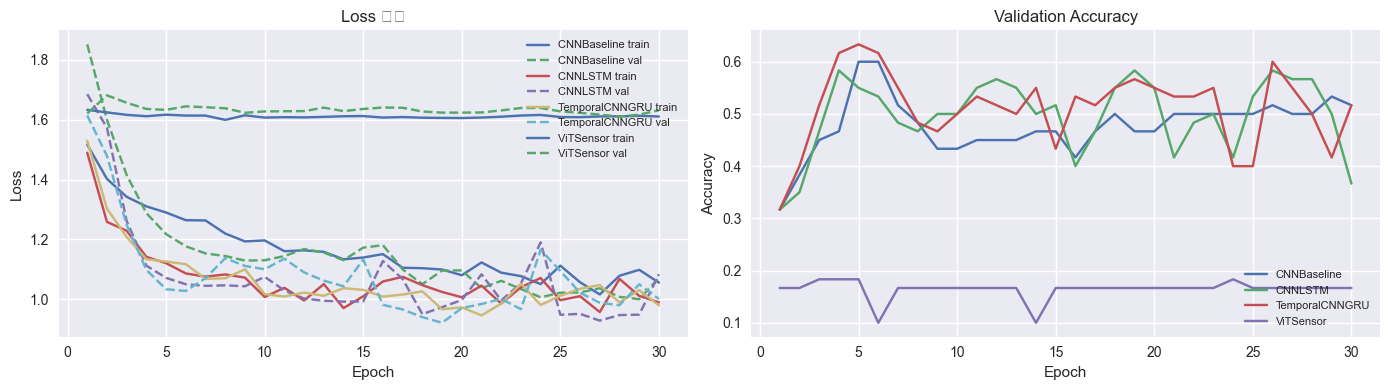

/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/1953493935.py:44: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/1953493935.py:44: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/Jae/Projects/squat_project/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Jae/Projects/squat_project/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


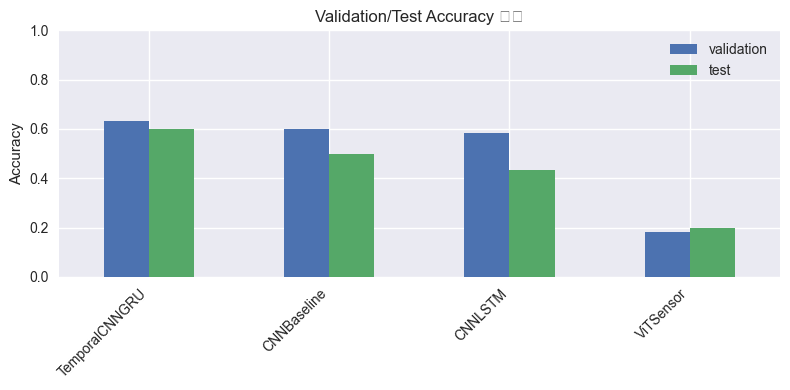

In [10]:
# 학습 곡선 및 성능 비교
if not histories:
    print('histories가 비어 있어 시각화를 건너뜁니다.')
else:
    history_frames = []
    for name, history in histories.items():
        frame = pd.DataFrame({
            'epoch': np.arange(1, len(history['train_loss']) + 1),
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc'],
            'model': name,
        })
        history_frames.append(frame)
    history_df = pd.concat(history_frames, ignore_index=True)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    for name, grp in history_df.groupby('model'):
        axes[0].plot(grp['epoch'], grp['train_loss'], label=f'{name} train')
        axes[0].plot(grp['epoch'], grp['val_loss'], linestyle='--', label=f'{name} val')
        axes[1].plot(grp['epoch'], grp['val_acc'], label=name)
    axes[0].set_title('Loss 곡선')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[0].legend(loc='upper right', fontsize=8)
    axes[1].legend(loc='lower right', fontsize=8)
    plt.tight_layout()
    plt.show()

    val_df = pd.DataFrame(val_metrics).T
    test_df = pd.DataFrame(test_results).T
    combined = val_df[['accuracy']].rename(columns={'accuracy': 'validation'})
    combined = combined.join(test_df[['accuracy']].rename(columns={'accuracy': 'test'}))
    combined = combined.sort_values('validation', ascending=False)

    ax = combined.plot(kind='bar', figsize=(8, 4))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation/Test Accuracy 비교')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 9. 라벨 없는 SSL 윈도우 추론
검증에서 가장 좋은 모델로 `data/manually_labeled/ssl`의 윈도우들을 분류합니다.


총 100개의 SSL 윈도우를 발견했습니다.
가장 높은 검증 정확도를 보인 모델: TemporalCNNGRU


,file,pred_class,pred_prob,description
0,subject1_ssl_window0.csv,CORRECT,0.863114,정자세 (Correct) — Hips drop below knees with neu...
1,subject1_ssl_window1.csv,CORRECT,0.863112,정자세 (Correct) — Hips drop below knees with neu...
12,subject1_ssl_window2.csv,CORRECT,0.863109,정자세 (Correct) — Hips drop below knees with neu...
18,subject1_ssl_window3.csv,CORRECT,0.863103,정자세 (Correct) — Hips drop below knees with neu...
19,subject1_ssl_window4.csv,CORRECT,0.863097,정자세 (Correct) — Hips drop below knees with neu...
20,subject1_ssl_window5.csv,CORRECT,0.863091,정자세 (Correct) — Hips drop below knees with neu...
21,subject1_ssl_window6.csv,CORRECT,0.863084,정자세 (Correct) — Hips drop below knees with neu...
22,subject1_ssl_window7.csv,CORRECT,0.863076,정자세 (Correct) — Hips drop below knees with neu...
23,subject1_ssl_window8.csv,CORRECT,0.863068,정자세 (Correct) — Hips drop below knees with neu...
24,subject1_ssl_window9.csv,CORRECT,0.863060,정자세 (Correct) — Hips drop below knees with neu...


/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/2567126287.py:57: UserWarning: Glyph 50952 (\N{HANGUL SYLLABLE WIN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/2567126287.py:57: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/2567126287.py:57: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/2567126287.py:57: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/2567126287.py:57: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/0n/7vdbl7ts6yl2vrl7hv5t30m80000gn/T/ipykernel_61272/2567126287.py:57: UserW

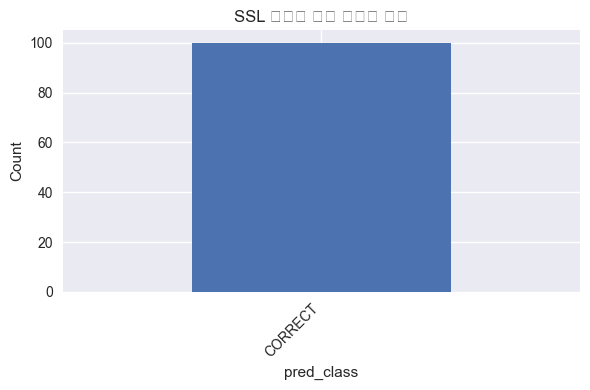

In [11]:
# SSL 윈도우 예측 및 시각화
unlabeled_dir = layout.manually_labeled / 'ssl'
unlabeled_files = sorted(unlabeled_dir.glob('*.csv'))
print(f'총 {len(unlabeled_files)}개의 SSL 윈도우를 발견했습니다.')

if not unlabeled_files:
    print('SSL 폴더가 비어 있어 예측을 건너뜁니다.')
else:
    best_model_name = max(val_metrics.items(), key=lambda kv: kv[1]['accuracy'])[0]
    print(f'가장 높은 검증 정확도를 보인 모델: {best_model_name}')
    best_model = trained_models[best_model_name].to(DEVICE).eval()

    def _resample(data: np.ndarray, length: int) -> np.ndarray:
        if data.shape[0] == length:
            return data
        base = np.linspace(0, data.shape[0] - 1, data.shape[0], dtype=np.float32)
        target = np.linspace(0, data.shape[0] - 1, length, dtype=np.float32)
        out = np.empty((length, data.shape[1]), dtype=np.float32)
        for idx in range(data.shape[1]):
            out[:, idx] = np.interp(target, base, data[:, idx])
        return out

    records = []
    for csv_path in unlabeled_files:
        df = pd.read_csv(csv_path)
        if 'timestamp' in df.columns:
            df = df.drop(columns=['timestamp'])
        numeric_df = df.select_dtypes(include=[np.number])
        if numeric_df.empty:
            continue
        data = numeric_df.to_numpy(dtype=np.float32)
        if data.shape[0] != TARGET_LENGTH:
            data = _resample(data, TARGET_LENGTH)
        tensor = torch.from_numpy(data.T.copy()).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            probs = best_model(tensor).softmax(dim=1).squeeze(0).cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_class = SquatClass(pred_idx)
        records.append({
            'file': csv_path.name,
            'pred_class': pred_class.name,
            'pred_prob': float(probs[pred_idx]),
            'description': SQUAT_CLASS_GUIDE[pred_class],
        })

    if not records:
        print('예측 가능한 SSL 윈도우가 없습니다.')
    else:
        ssl_df = pd.DataFrame(records).sort_values('pred_prob', ascending=False)
        display(ssl_df.head(10))

        plt.figure(figsize=(6, 4))
        ssl_df['pred_class'].value_counts().plot(kind='bar')
        plt.title('SSL 윈도우 예측 클래스 분포')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


## 10. 결과 저장


In [12]:
summary = {
    "val_metrics": val_metrics,
    "test_metrics": test_results,
    "config": config.__dict__,
}

summary_path = RESULTS_DIR / "foundation_model_results.json"
with summary_path.open("w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

summary_path

PosixPath('/Users/Jae/Projects/squat_project/results/foundation_models/foundation_model_results.json')

필요에 따라 `histories`를 활용해 학습 곡선을 시각화하거나, 혼동 행렬과 같은 추가 분석을 이어가세요.